In [163]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [164]:
from __future__ import print_function, absolute_import, division
import tensorflow as tf

In [165]:
print(tf.__version__)
tf.test.is_gpu_available()

1.13.1


True

In [166]:
from tensorflow.estimator import RunConfig
from training_functions import make_tfr_input_fn

# Using a Tensorflow Estimator
As you can see, the ```Estimator``` is the central working horse of ML Engineering. We'll have to provide it with 
- a model function: The model function creates appropriate versions of the hypothesis together with some parameters and the tools to evaluate and train the model.
    - The model function returns ```EstimatorSpec```s for the different phases of the ML lifecycle
- ```EvalSpec``` and ```TrainSpec``` objects that determine the physical characteristics of the training and evaluation phases.
- a ```RunConfig``` that essentially describes the execution environment.

After that, the estimator performs all steps independently, creates logfiles, safe-points, performance metrics, and the entire model update life cycle. At the end we get to a model that we can use for prediction.

### Configuration

In [167]:
import tempfile
temp_dir = tempfile.gettempdir()

import os
file_pattern = os.path.join(temp_dir, "training.tfr-*")
file_pattern

training_pattern = os.path.join(temp_dir, "training.tfr-*")
eval_pattern = os.path.join(temp_dir, "eval.tfr-*")

# remove this directory to start from scratch
model_dir = os.path.join(temp_dir, "models" )

In [168]:
training_pattern = 'self_play_data/*-*.tfr'
eval_pattern = 'deleteme.tfr'

In [147]:
![ -d $model_dir ] && echo "Really delete $model_dir?"

Really delete /tmp/models?


In [148]:
# Uncomment if you really want to delete the model and start from scratch
!rm -rf $model_dir

In [169]:
training_options={
    'num_epochs': None,  # repeat infinitely
    'shuffle_buffer_size': 1000,
    'prefetch_buffer_size': 1000,
    'reader_num_threads': 10,
    'parser_num_threads': 10,
    'sloppy_ordering': True,
    'distribute': False}

eval_options={
    'num_epochs': None,  # repeat infinitely
    'shuffle_buffer_size': 100,
    'prefetch_buffer_size': 10,
    'reader_num_threads': 10,
    'parser_num_threads': 10,
    'sloppy_ordering': True,
    'distribute': False}

test_options={
    'num_epochs': None,  # repeat infinitely
    'shuffle_buffer_size': 1000,
    'prefetch_buffer_size': 1000,
    'reader_num_threads': 10,
    'parser_num_threads': 10,
    'sloppy_ordering': True,
    'distribute': False}

### Input Functions

In [177]:
train_input_fn = make_tfr_input_fn(
    filename_pattern=training_pattern,
    batch_size=256,
    options = training_options)

eval_input_fn = make_tfr_input_fn(
    filename_pattern=eval_pattern,
    batch_size=80,
    options = eval_options)

### The model_function
The model function provides ```EstimatorSpec```s, i.e. specifications how to build the model for each of the different cases: training, evaluation and test. Indeed, some models require the actual function to differ slightly between training and evaluation. The model function is the place to specify what exactly is to be calculated during each phase of the ML process. In our case, though, all specifications are essentially the same. Typically, you'd expect the *data scientist* to provide this function, so it's not so important that you fully understand the concept here.

In [178]:
class ResNet:
    """
    After sufficient training, this instance of ResNet takes an array of dimensions 10x10 
    and returns 1 if the array contains the pattern you tought it to recognize.
    """
    def __init__(self, size, n_blocks, n_filters, inps=None, lbls=None):
        
        if inps == None:
            inps = tf.placeholder(name="inp_resnet", 
                                  shape=[None, size+2, size+2, 2], 
                                  dtype=tf.float32)
            
        if lbls == None:
            lbls = tf.placeholder(name="lbl_resnet", 
                                  shape=[None, size+2, size+2, 1], 
                                  dtype=tf.float32)
        self.inps = inps
        self.lbls = lbls

        out = self.inps
        for i in range(n_blocks):
            out = self._res_block(out, n_filters)

        self.out = tf.layers.conv2d(kernel_size=1, filters=1, inputs=out, 
                               padding='same', activation=None)

        # TODO: Just wouldn't work, minimizes until a certain point then losses go up again
        #lbls_1dim = tf.reshape(self.lbls, [-1, 21*21, 1])
        #outs_1dim = tf.reshape(self.out, [-1, 21*21, 1])
        #losses = tf.nn.softmax_cross_entropy_with_logits_v2(lbls_1dim, outs_1dim, axis=1)
        #self.loss = tf.reduce_sum(losses)
        self.loss = tf.losses.mean_squared_error(self.lbls, self.out)
        
        self.errors = tf.losses.mean_squared_error(self.lbls, self.out)
        self.accuracy=tf.reduce_sum(tf.cast(self.errors < .1, dtype=tf.int64))

        self.optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
        self.trainer = self.optimizer.minimize(self.loss)
    
    
    def _res_block(self, inp, filters, activation='relu'):
      
        out1_3 = tf.layers.conv2d(kernel_size=3, filters=filters, inputs=inp, 
                                  padding='same', activation=activation)
        out1_5 = tf.layers.conv2d(kernel_size=5, filters=filters, inputs=inp, 
                                  padding='same', activation=activation)
        out1 = tf.concat([out1_3, out1_5], axis=3)
        
        out2_3 = tf.layers.conv2d(kernel_size=3, filters=filters, inputs=out1, 
                                  padding='same', activation=activation)
        out2_5 = tf.layers.conv2d(kernel_size=5, filters=filters, inputs=out1, 
                                  padding='same', activation=activation)
        out2 = tf.concat([out2_3, out2_5], axis=3)
        
        out3_3 = tf.layers.conv2d(kernel_size=3, filters=filters, inputs=out2, 
                                  padding='same', activation=activation)
        out3_5 = tf.layers.conv2d(kernel_size=5, filters=filters, inputs=out2, 
                                  padding='same', activation=activation)
        out3 = tf.concat([out3_3, out3_5], axis=3)
        
        bn = tf.layers.batch_normalization(inputs=out3)

        skip = tf.layers.conv2d(kernel_size=1, filters=2, inputs=inp, 
                                padding='same', activation=None)
        
        return tf.concat([skip, bn], axis=3)

In [179]:
features, labels = train_input_fn()

In [180]:
features

{'state': <tf.Tensor 'IteratorGetNext_7:0' shape=(256, 21, 21, 2) dtype=float32>}

In [181]:
resnet = ResNet(19, n_blocks=10, n_filters=32, inps=features['state'], lbls=labels)

In [182]:
def model_function(features, labels, mode):

    my_input_layer = features['state']

    resnet = ResNet(19, n_blocks=2, n_filters=32, inps=my_input_layer, lbls=labels)
    hypothesis = resnet.out

    #
    # For predictions, we just need the hypothesis.
    #
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(
            tf.estimator.ModeKeys.PREDICT, 
            predictions=hypothesis)

    #
    # For evaluation, we need to provide the loss function, too.
    #
    #loss = tf.losses.mean_squared_error(labels, hypothesis)
    
    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(
            tf.estimator.ModeKeys.EVAL,
            loss = resnet.loss)

    
    #
    # And for training, we also need the optimizer
    #
    train_op = resnet.trainer
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        optimizer = tf.train.AdamOptimizer(1e-3)
        #train_op = optimizer.minimize(loss)

        global_step = tf.train.get_global_step()
        update_global_step = tf.assign(global_step, global_step + 1, 
                                       name = 'update_global_step')

        return tf.estimator.EstimatorSpec(
            tf.estimator.ModeKeys.TRAIN,
            loss = resnet.loss, 
            train_op = tf.group(train_op, update_global_step))    
    


### Serving Input Receiver
This function returns a function that is going to be called by the estimator to create a ServingInputReciever. Sounds odd, but is pretty straight-forward. First, we provide a function that will return a tensor. We don't provide the tensor, because the tensor will have to be created in the context (graph and session) of the estimator methods. We use a function to create a function because we're passing a parameter that's necessary but not available to the estimator at runtime. Fine. But why are we doing that, anyway?

Remember the scaling of the $\beta$s that we performed with our Beam pipeline. We saved the transform function as the last step of the pipeline. Here, we dig it out again and provide it to the estimator so it can attach it to the front of its computational graph such that the same scaling is applied to the *signature* data.

In [183]:
import tensorflow_transform as tft
def make_tft_serving_input_fn(metadata_dir):
    
    def _input_fn():
    
        # This is what signature data looks like: no feature cross yet
        placeholders = {
            'state': tf.placeholder(name='state', shape=[None, 21, 21, 2], dtype=tf.float32)
        }
    
        transform_output = tft.TFTransformOutput(transform_output_dir=metadata_dir)
        features = placeholders #transform_output.transform_raw_features(placeholders)
            
        return tf.estimator.export.ServingInputReceiver(features, placeholders)

    return _input_fn


### The Estimator

In [184]:
config = RunConfig(
    model_dir              = model_dir,
    save_summary_steps     = 20000,
    save_checkpoints_steps = 20000,
    log_step_count_steps   = 1000)

In [158]:
!mkdir /tmp/metadata
metadata_dir = os.path.join(temp_dir, 'metadata')
!ls $metadata_dir

mkdir: cannot create directory '/tmp/metadata': File exists


In [185]:
serving_input_fn = make_tft_serving_input_fn(model_dir)
exporter = tf.estimator.LatestExporter('exporter', serving_input_fn)

In [186]:
estimator = tf.estimator.Estimator(
        config=config,
        model_fn=model_function)

INFO:tensorflow:Using config: {'_num_worker_replicas': 1, '_eval_distribute': None, '_train_distribute': None, '_is_chief': True, '_log_step_count_steps': 1000, '_protocol': None, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb9635cd2b0>, '_save_checkpoints_steps': 20000, '_task_id': 0, '_experimental_distribute': None, '_master': '', '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_global_id_in_cluster': 0, '_keep_checkpoint_every_n_hours': 10000, '_task_type': 'worker', '_service': None, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_save_checkpoints_secs': None, '_device_fn': None, '_model_dir': '/tmp/models', '_evaluation_master': '', '_save_summary_steps': 20000}


In [188]:
max_steps = (
    5000 *    # total number of records
    5000 /       # number of epochs I want for training
    256       # batch size
)

print("Training up to %s steps now..." % max_steps)

train_spec = tf.estimator.TrainSpec(
    input_fn=train_input_fn, 
    max_steps=max_steps)

eval_spec = tf.estimator.EvalSpec(
    input_fn=eval_input_fn, exporters=exporter,
    steps = 2, # 2 batches for evaluation
    
    throttle_secs=1, # technical stuff - don't bother
    start_delay_secs=0)

Training up to 97656.25 steps now...


In [189]:
tf.estimator.train_and_evaluate(
    estimator,
    train_spec=train_spec,
    eval_spec=eval_spec)

INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps 20000 or save_checkpoints_secs None.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/models/model.ckpt-31250
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 31250 into /tmp/models/model.ckpt.
INFO:tensorflow:loss = 3.2666435e-06, step = 31250
INFO:tensorflow:global_step/sec: 23.7596
INFO:tensorflow:loss = 2.5169136e-05, step = 32250 (42.089 sec)
INFO:tensorflow:global_step/sec: 23.5975
INFO:tensorflow:loss = 1.7111934e-05, step = 33250 (42.377 sec)
INFO:tensor

({'global_step': 97657, 'loss': 1.7644379e-06},
 [b'/tmp/models/export/exporter/1560706006'])

In [190]:
import os
model_dir = os.path.join("/tmp/", "models/export/exporter")
versions = !ls $model_dir
print( "Versions: %s" % versions)
latest_version = max(versions)
latest_model = os.path.join(model_dir, str(latest_version))
!echo $latest_model
!ls $latest_model

Versions: ['1560700849', '1560703941', '1560704830', '1560705719', '1560706006']
/tmp/models/export/exporter/1560706006
saved_model.pb	variables


In [191]:
estimator = tf.contrib.predictor.from_saved_model(latest_model)

INFO:tensorflow:Restoring parameters from /tmp/models/export/exporter/1560706006/variables/variables


In [192]:
def _parse_function(example):
    return tf.parse_single_example(example, feature_spec)

In [193]:
dataset = tf.data.TFRecordDataset("deleteme.tfr")

In [194]:
N_p=21
feature_spec = {
    'state': tf.FixedLenFeature([N_p * N_p * 2], tf.float32),
    'distr': tf.FixedLenFeature([N_p * N_p], tf.float32)
}
decoded = dataset.map(_parse_function).make_one_shot_iterator().get_next()

In [195]:
with tf.Session() as sess:
    res2 = sess.run(decoded)

In [196]:
res2['state'].shape, res2['distr'].shape

((882,), (441,))

In [197]:
from wgomoku import to_matrix12
sample=res2['state'].reshape(1,21,21,2)
m12 = to_matrix12(sample, 21)
m12

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 1, 1, 1, 2, 2, 1, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 1, 1, 2, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0,

In [198]:
distr = estimator({'state': sample})
predi = distr['output'].reshape(21,21)[1:-1].T[1:-1].T
predi.shape

(19, 19)

In [199]:
from wgomoku import (
    GomokuBoard,
    HeuristicGomokuPolicy, Heuristics, GomokuTools as gt)

In [200]:
size=19
p = HeuristicGomokuPolicy(style = 2, bias=.5, topn=5)
heuristics = Heuristics(kappa=3.0)

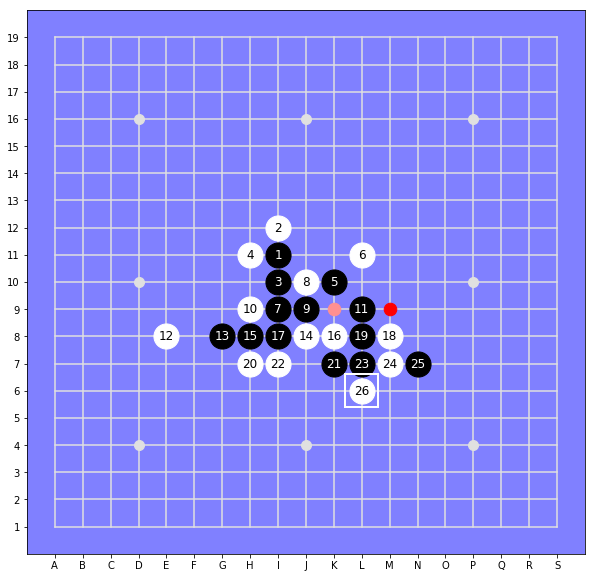

In [201]:
import numpy as np
black = [gt.m2b(p, 19) for p, v in list(np.ndenumerate(m12)) if v == 1]
white = [gt.m2b(p, 19) for p, v in list(np.ndenumerate(m12)) if v == 2]
pairs = zip(black, white)

moves = []
for b,w in pairs: 
    moves.append(b)
    moves.append(w)
board = GomokuBoard(N=19, stones=moves, heuristics=heuristics, 
                    disp_width=10)
board.display(probas=lambda x: predi)

In [202]:
from wgomoku import create_sample
smp = create_sample(board.stones, 19, 1-board.current_color)

In [203]:
smp.shape

(21, 21, 2)

In [204]:
sample = smp.reshape(1, 21, 21, 2)

In [205]:
distr = estimator({'state': sample})

In [206]:
def ai_policy(board):
    smp = create_sample(board.stones, 19, 1-board.current_color)
    sample = smp.reshape(1, 21, 21, 2)
    pred = estimator({'state': sample})['output'][0].reshape(21,21)
    return pred[1:-1].T[1:-1].T

In [207]:
ai_policy(board).shape

(19, 19)

In [208]:
A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U = \
    1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
BLACK=0
WHITE=1
EDGES=2

In [396]:
board.undo().undo().undo().undo().undo().undo().undo().undo(True);

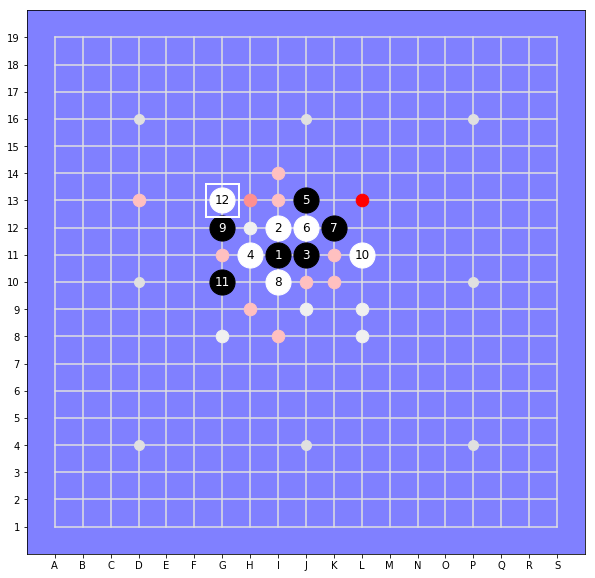

In [397]:
board.display(probas = ai_policy)

In [398]:
from wgomoku import StochasticMaxSampler

In [399]:
sampler.choices[0][1]

(7, 12)

M 7


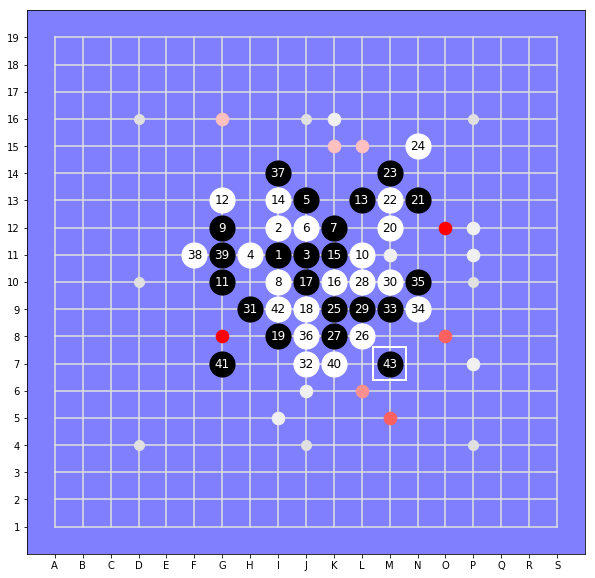

In [430]:
sampler = StochasticMaxSampler(np.ndenumerate(ai_policy(board)), bias=8, topn=5)
rc = sampler.choices[0][1]
x, y = gt.m2b(rc, 19)
print(chr(64+x), y)
board.set(x, y);
board.display(probas = ai_policy)

In [385]:
board.set(H,8);

In [394]:
board.undo()

[(0.55414367, (11, 11), 0.44585627, 0.28087252), (0.294051, (10, 8), 0.2600927, 0.2135027), (0.19006908, (10, 10), 0.10398193, 0.09890008), (0.09498331, (11, 7), 0.09508577, 0.08772035), (0.0, (7, 7), 0.09498331, 0.08758558)]


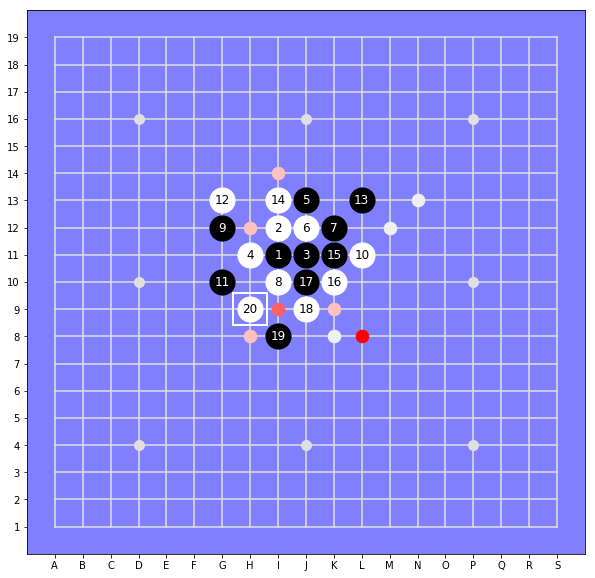

In [393]:
board.display(probas = ai_policy)
sampler = StochasticMaxSampler(np.ndenumerate(ai_policy(board)), bias=8, topn=5)
print(sampler.choices)
